Data cleaning and analysis for A/B testing

In [84]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [85]:
file_path = "AB_Test_Results.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sergylog/ab-test-data",
  file_path,
)

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Do some initial data cleaning and visualization:

In [86]:
df.groupby('VARIANT_NAME')['USER_ID'].count()

VARIANT_NAME
control    4984
variant    5016
Name: USER_ID, dtype: int64

In [87]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [88]:
# Identify duplicates
df.loc[df.duplicated(subset=['USER_ID', 'REVENUE']) == True].groupby('VARIANT_NAME')['USER_ID'].count() # duplicates balanced between control and treat group

VARIANT_NAME
control    1800
variant    1783
Name: USER_ID, dtype: int64

In [89]:
df = df.drop_duplicates(subset=['USER_ID', 'REVENUE']).reset_index(drop=True)

In [90]:
df.describe()

,USER_ID,REVENUE
count,6417.000000,6417.000000
mean,4982.504597,0.154974
std,2896.616274,2.892913
min,2.000000,0.000000
25%,2463.000000,0.000000
50%,4969.000000,0.000000
75%,7510.000000,0.000000
max,10000.000000,196.010000


<Axes: xlabel='REVENUE', ylabel='Count'>

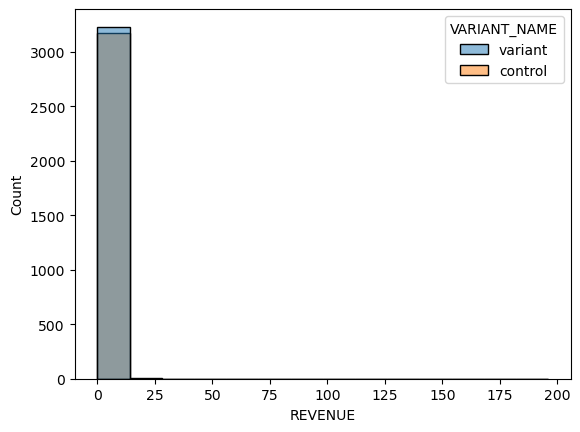

In [91]:
import seaborn as sns
sns.histplot(data=df, x='REVENUE', hue='VARIANT_NAME')

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

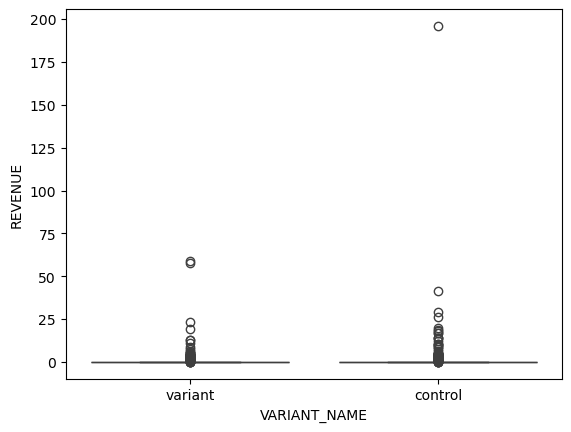

In [92]:
sns.boxplot(data=df, x='VARIANT_NAME', y='REVENUE')

In [93]:
df.sort_values(by='REVENUE',ascending=False).iloc[:20]

,USER_ID,VARIANT_NAME,REVENUE
1349,3342,control,196.01
4811,2881,variant,58.63
5423,7206,variant,57.46
6190,6792,control,41.53
5678,2166,control,29.32
6084,831,control,25.98
2224,7356,variant,23.04
4789,1053,control,20.07
4112,3684,variant,19.47
4287,282,control,18.56


<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

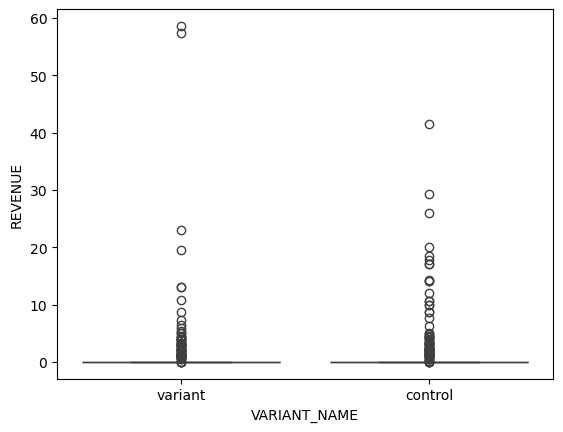

In [94]:
df_cleaned = df.loc[df.USER_ID != 3342]
sns.boxplot(data=df_cleaned, x='VARIANT_NAME', y='REVENUE')

In [95]:
df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3183.0,0.140430,1.448086,0.0,0.0,0.0,0.0,41.53
variant,3233.0,0.108713,1.636514,0.0,0.0,0.0,0.0,58.63


We see that revenue values for the `control` and `variant` groups have different means (0.14 vs. 0.11) as well as different standard deviations (1.45 vs. 1.64). In both cases the data is highly right-skewed with most customers spending $0. 

We now run a Shapiro-Wilk test on the cleaned revenue data to check for normality. We will reject the null hypothesis if the p-value of the test <0.01

In [96]:
from scipy import stats
revenue = df_cleaned['REVENUE']
res = stats.shapiro(revenue)
print(f"The test statistic for the Shapiro-Wilk test is: {res.statistic}")
print(f"The p-value of the test statistic is: {res.pvalue}")

The test statistic for the Shapiro-Wilk test is: 0.05305247528540025
The p-value of the test statistic is: 2.5210089534272607e-101


Because p<<0.01, we can reject the null hypothesis that the distribution of revenue is normal. However, we can still implement a student's t-test of the difference-in-means due to the central limit theorem. We will implement a one-sided test for two samples that mean revenue for the treatment condition is greater than mean revenue for the control condition. Our null hypothesis is that these two conditions have equal mean revenue. We do _not_ assume equal variances between the two samples. We set alpha=0.01.

In [97]:
treatment = df_cleaned.loc[df_cleaned['VARIANT_NAME']=='variant']['REVENUE']
control = df_cleaned.loc[df_cleaned['VARIANT_NAME']=='control']['REVENUE']

t_test = stats.ttest_ind(a=treatment, b=control, equal_var=False, alternative='greater')
print(f"The test statistic of the t-test is {t_test.statistic} with {t_test.df} degrees of freedom")
print(f"The p-value of this test is {t_test.pvalue}")

The test statistic of the t-test is -0.8224538170395683 with 6342.410912048745 degrees of freedom
The p-value of this test is 0.7945752101758432


Because p>0.01, we cannot reject the null hypothesis that mean revenue for the treatment condition is equal to the control condition.

We now conduct a power test to check whether our T-test could have detected the given effect size in our sample.

In [98]:
from statsmodels.stats.power import TTestIndPower
# Get standrd deviations, means of our samples, and standard errors for sample means
std_control = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['std'][0]
std_variant = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['std'][1]

mean_control = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['mean'][0]
mean_variant = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['mean'][1]

n_control = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['count'][0]
n_variant = df_cleaned.groupby(df_cleaned.VARIANT_NAME).describe()['REVENUE']['count'][1]

# Get values for TTestIndPower
effect=np.sqrt(((n_variant - 1)*std_variant**22 + (n_control - 1)*std_control**2) / (n_control + n_variant - 2)) # pooled SD


# Check the power of our t_test
t_testPower = TTestIndPower()
power = t_testPower.power(effect_size=effect,
    nobs1=n_control,
    alpha=0.01,
    ratio = n_variant / n_control,
    alternative='larger'
)

print(f"The power of our test (1 - the probability of a false negative) is: {power}")

The power of our test (1 - the probability of a false negative) is: 1.0


We see that the power of our test is indistinguishable from 1.0, meaning that we were virtually certain to reject the null hypothesis if it had been false. 

To check our findings, we also implement a Mann-Whitney U-test as a non-parametric test on the difference in mean revenue between the treatment and control group. We again choose alpha=0.01 and a one-sided test. 

In [99]:
from scipy.stats import mannwhitneyu
MW_test = mannwhitneyu(treatment, control, alternative='greater')
print(f'The MW test statistic is {MW_test.statistic}')
print(f'The p-value of the MW test is {MW_test.pvalue}')

The MW test statistic is 5131764.0
The p-value of the MW test is 0.7567551928863474


Because p > 0.01, we cannot reject the null hypothesis that the two samples are drawn from the same distribution. 

Next, we implement a randomization test to estimate the difference in mean revenue between the treatment and control gorup. This non-parametric procedure will provide additional evidence regarding the effect of the treatment campaign on revenue: 

In [139]:
import random
import matplotlib.pyplot as plt

mean_diffs = np.mean(treatment) - np.mean(control)

def randomization_test(x, n_treat, n_control):
    n = len(x)
    idx_treat = random.choices(x.index, k=n_treat)  # Sample with replacement from the actual index
    idx_control = list(set(x.index) - set(idx_treat))  # Remaining indices for control
    return x.loc[idx_treat].mean() - x.loc[idx_control].mean()

random_diffs = [randomization_test(x=df_cleaned.REVENUE, n_treat=len(treatment), n_control=len(control)) for i in range(1000)]

0.233

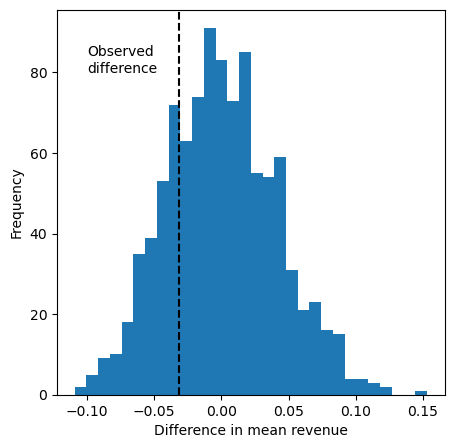

In [149]:
fig,ax = plt.subplots(figsize=(5,5))
ax.hist(random_diffs, bins=30)
ax.axvline(x = mean_diffs, color = 'black', linestyle='--')
ax.text(-0.10,80, 'Observed\ndifference')
ax.set_xlabel('Difference in mean revenue')
ax.set_ylabel('Frequency')
np.mean(mean_diffs > random_diffs)

We see that the observed difference in means is greater than only 23% of the differences-in-means in the bootstrap distribution. This indicates that the observed difference in means between the treatment and control is within the range of ordinary variation among all our users. 

In [ ]:
# Create factor variables for zero revenue, low revenue (<$10), and high revenue customers (>=$10)
df_cleaned['ZERO_REV'] = [1 if row == 0 else 0 for row in df_cleaned['REVENUE']]
df_cleaned['LOW_REV'] = [1 if ((row > 0) & (row <= 10)) else 0 for row in df_cleaned['REVENUE']]
df_cleaned['HIGH_REV'] = [1 if row > 10 else 0 for row in df_cleaned['REVENUE']]

In [91]:
df_cleaned.loc[df_cleaned['LOW_REV']==1]['REVENUE'].describe()

count    130.000000
mean       2.614154
std        2.078031
min        0.020000
25%        1.250000
50%        2.165000
75%        3.505000
max        9.990000
Name: REVENUE, dtype: float64

In [92]:
df_cleaned.loc[df_cleaned['HIGH_REV']==1]['REVENUE'].describe()

count    21.000000
mean     21.839048
std      14.085605
min      10.630000
25%      12.990000
50%      17.080000
75%      23.040000
max      58.630000
Name: REVENUE, dtype: float64

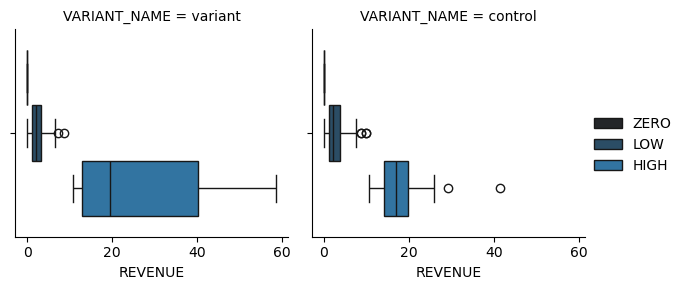

In [171]:
# Create factor variable version of revenue level
df_cleaned['REV_LEVEL'] = [
    'ZERO' if row == 0 else
    'LOW' if ((row > 0) & (row <= 10)) else
    'HIGH' if row > 10 else NaN
    for row in df_cleaned['REVENUE']
]

# Box plot of levels
grid = sns.FacetGrid(data=df_cleaned, col='VARIANT_NAME')
grid.map_dataframe(sns.boxplot, x='REVENUE', hue='REV_LEVEL')
grid.add_legend()

Our boxplots provide some evidence that there may be a difference between the variant and the mean for high spenders compared to the control. We also plot a smoothed kernel density estimator (left-censored at zero):

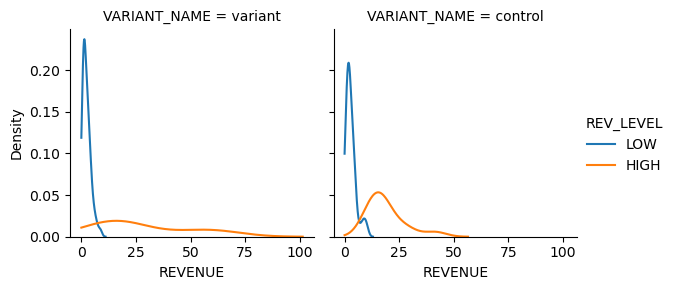

In [ ]:
# Visualize non-zero revenue categories with a kernel density plot
df_cleaned_nonzero = df_cleaned.loc[df_cleaned['REV_LEVEL'].isin(['LOW', 'HIGH'])]
grid = sns.FacetGrid(data=df_cleaned_nonzero, col='VARIANT_NAME', hue='REV_LEVEL')
grid.map_dataframe(sns.kdeplot, x='REVENUE', clip=(0, np.inf))
grid.add_legend()

In [186]:
df_cleaned.groupby(['VARIANT_NAME', 'REV_LEVEL'])['USER_ID'].count()

VARIANT_NAME  REV_LEVEL
control       HIGH           14
              LOW            65
              ZERO         3104
variant       HIGH            7
              LOW            65
              ZERO         3161
Name: USER_ID, dtype: int64

Because of the small number of observations in the 'LOW' and 'HIGH' categories, and evidence of inconsistent variances in among the levels of 'REV_LEVEL', we can perform a chi-square test: 

In [212]:
import statsmodels.api as sm
x_tab = pd.crosstab(df_cleaned['VARIANT_NAME'], df_cleaned['REV_LEVEL'])
print(x_tab)

REV_LEVEL     HIGH  LOW  ZERO
VARIANT_NAME                 
control         14   65  3104
variant          7   65  3161


In [213]:
table = sm.stats.Table(x_tab)
result = table.test_nominal_association()
print(result.pvalue)

0.29193804064535134


We also test the ordinal association between the levels using a Cochran-Armitage trend test:

In [232]:
result = table.test_ordinal_association()
print(result)

null_mean   6379.329800498753
null_sd     7.235484599407158
pvalue      0.2891077664449685
statistic   6387.0
zscore      1.060080965672387


Finally, we perform a Somer's D test for ordinal data:

In [233]:
somers_d = stats.somersd(x_tab, alternative='less')
print(somers_d.statistic)
print(somers_d.pvalue)

0.0025932306050187944
0.7532639540096518


These tests suggest, however, that there is no association between revenue level and test condition.